In [446]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

## Edges detection

In [447]:
img = cv2.imread('test_images/test7.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [448]:
def detect_edges(img, s_thresh=(100, 255), sx_thresh=(15, 255), canny=True, blur=True):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    
    # Sobel x
    if canny:
        edges = cv2.Canny(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 100, 300)
    else:
        edges = cv2.Sobel(l_channel, cv2.CV_64F, 1, 1)
    
    abs_edges = np.absolute(edges) # Absolute x derivative to accentuate lines away from horizontal
    scaled_edges = np.uint8(255*abs_edges/np.max(abs_edges))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_edges)
    sxbinary[(scaled_edges >= sx_thresh[0]) & (scaled_edges <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    if blur:
        combined_binary = cv2.blur(combined_binary, (5,5))
    
    return combined_binary

## Perspective warp

In [449]:
src_points = [(0,0.70),(1,0.70),(0,1),(1,1)]
dst_points = [(0,0), (1, 0), (0,1), (1,1)]
dst_shape = (1280, 720)

In [450]:
def perspective_warp(img):
    # Create real pixels poins from percentages proportions
    img_size = np.float32([(img.shape[1], img.shape[0])])
    src = np.float32(src_points) * img_size
    dst = np.float32(dst_points) * np.float32(dst_shape)
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, dst_shape)
    
    return warped

Text(0.5, 1.0, 'Warped Image')

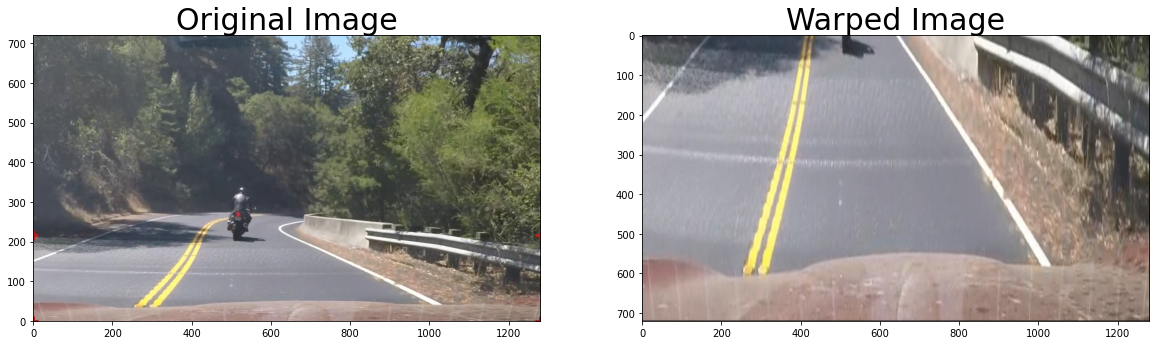

In [451]:
dst = perspective_warp(img)

# Visualize perspective warp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, extent=[0, 1280, 0, 720])
for point in src_points:
    ax1.plot(int(img.shape[1]*point[0]), int(720 - img.shape[0]*point[1]), '+', markersize=10, markeredgewidth=3, color='firebrick')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Warped Image', fontsize=30)

### Improvement of the perspective warp with point detection

What we tried to do in this part is to improve the perspective warp by determining roughly where the lines are going to make a better lane detection afterward. We decided to use Hough line detections to get the lanes and then get the intersection with the horizon to create the trapezis needed for the perspective warp.

In [452]:
def detect_rough_lines(img):
    img_with_lines = np.copy(img)
    img_with_lines = img_with_lines[int(720 / 2):,:,:]

    edges = detect_edges(img_with_lines, canny=True, blur=False)

    lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
    for line in lines:
        for rho, theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv2.line(img_with_lines, (x1,y1), (x2,y2), (0,0,255), 2)
    return img_with_lines

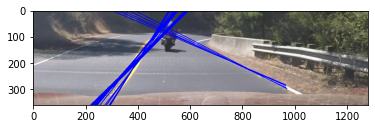

In [453]:
img_with_horizon = detect_rough_lines(img)
cv2.line(img_with_horizon, (0, int(0.7 * 720)), (1280, int(0.7 * 720)), (255,0,0), 4)
plt.imshow(img_with_horizon)

In [454]:
y = int(0.2 * 720)

def detect_intersections(img, margin=70):
    img_with_lines = detect_rough_lines(img)
    
    intersections = []
    for x, pixel in enumerate(img_with_lines[y]):
        if np.array_equal(pixel, [0, 0, 255]):
            intersections.append(x)

    left_point = min(intersections) - margin
    right_point = max(intersections) + margin
    
    return left_point, right_point

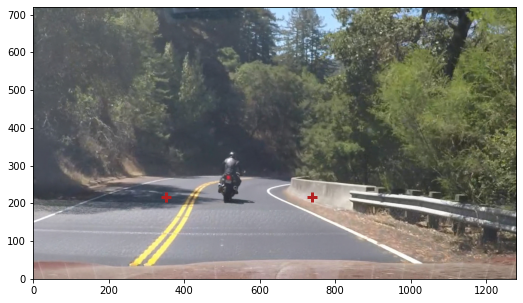

In [455]:
left_point, right_point = detect_intersections(img)

f, (ax1) = plt.subplots(1, 1, figsize=(10,5))
ax1.imshow(img, extent=[0, 1280, 0, 720])
ax1.plot(left_point, 720 / 2 - y, '+', markersize=10, markeredgewidth=3, color='firebrick')
ax1.plot(right_point, 720 / 2 - y, '+', markersize=10, markeredgewidth=3, color='firebrick')

In [456]:
def perspective_warp_with_detection(img, original):
    # Create real pixels poins from percentages proportions
    img_size = np.float32([(img.shape[1], img.shape[0])])
    src = np.float32(src_points) * img_size
    
    left_point, right_point = detect_intersections(original)
    src[0][0] = left_point
    src[1][0] = right_point
    
    dst = np.float32(dst_points) * np.float32(dst_shape)
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, dst_shape)
    
    return warped

Text(0.5, 1.0, 'Warped Image')

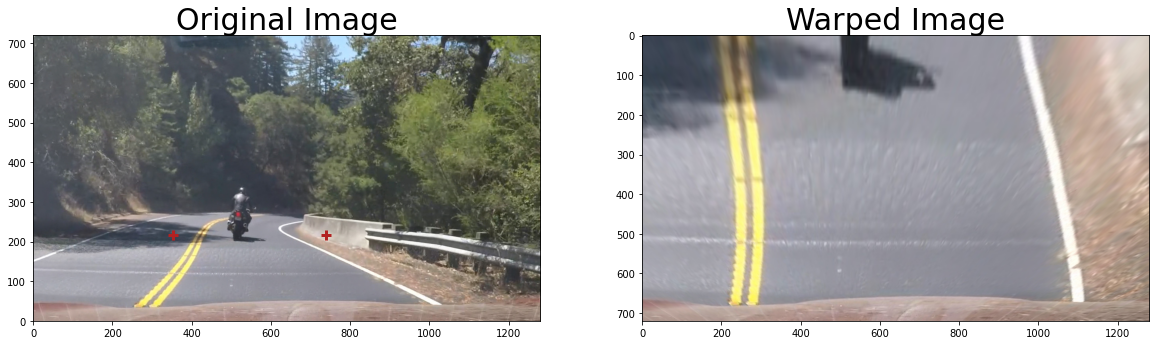

In [457]:
left_point, right_point = detect_intersections(img)
dst = perspective_warp_with_detection(img, img)

# Visualize perspective warp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, extent=[0, 1280, 0, 720])
ax1.plot(left_point, 720 / 2 - y, '+', markersize=10, markeredgewidth=3, color='firebrick')
ax1.plot(right_point, 720 / 2 - y, '+', markersize=10, markeredgewidth=3, color='firebrick')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Warped Image', fontsize=30)

### Inverse function

In [458]:
def inv_perspective_warp_with_detection(img, original):
    # Create real pixels poins from percentages proportions
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = np.float32(src_points) * img_size
    
    left_point, right_point = detect_intersections(original)
    src[0][0] = left_point
    src[1][0] = right_point
    
    dst = np.float32(dst_points) * np.float32(dst_shape)
    
    M = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, dst_shape)
    return warped

## Lane detection

Text(0.5, 1.0, 'Preprocessed Image')

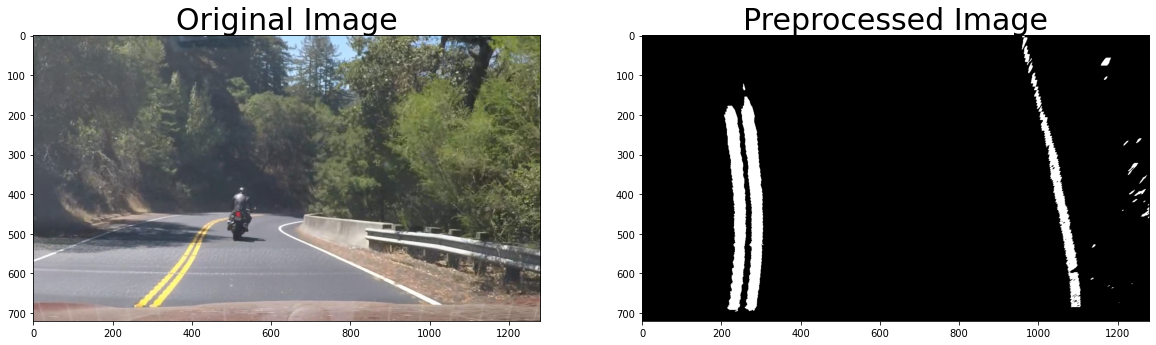

In [459]:
dst = undistort(img)
dst = detect_edges(dst, canny=True, blur=False)
dst = perspective_warp_with_detection(dst, img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Preprocessed Image', fontsize=30)